# Pineapple Net Incident Report

Pineapple Net is an internet service provider promising a reliable and fast internet connectin with download speeds of up to 1000Mbps. 

This report investigates the various network status incidents posted on the Pineapple Net website.

In [1]:
#options to control restarting the kernel and running the code
#set to false to avoid redownloading data

collect_incident_links = False
collect_incident_content = False

In [2]:
#import packages

from urllib.request import urlopen
import time
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
pd.pandas.set_option('display.max_columns', None)

Each incident on Pineapple Net's website has its own dedicated page.

The incidents can be accessed via the link https://status.pinapple.net.au/incidents/incident_id

To find these links, one has to manually click through the history located at:
https://status.pineapple.net.au/history?page=page_number

There are six pages, numbered 1 to 6, with information about historic incidents.

Each page contains links to multiple incidents.

Unfortunately, the incidents are not linked in an obvious way using href.

The incident ID was therefore located manually by viewing the page source, and the preceding characters recorded. 

In [3]:
#this code searches for that pattern of preceding characters and extracts the next 12 characters, in a while loop until there are no more incident IDs to be found.
#the incident IDs are used to generate webpage links to the corresponding incident log

if collect_incident_links:
    find_this = '{&quot;code&quot;:&quot;'
    skip_chars = len(find_this)

    incident_ids = []

    for page_number in range(1,7,1):
        url = f'https://status.pineapple.net.au/history?page={page_number}'
        page = urlopen(url)
        html_bytes = page.read()
        html = html_bytes.decode("utf-8")

        start_char = html.find(find_this)
        length_incident_id = len('5yht5whdwlym')
        running_offset = 0
        while start_char != -1:
            start_of_incident_id = start_char + skip_chars
            incident_id = html[running_offset + start_of_incident_id : running_offset + start_of_incident_id + length_incident_id]

            incident_ids.append(incident_id)
            running_offset += start_of_incident_id + length_incident_id
            start_char = html[running_offset:].find(find_this)

        time.sleep(1 + 5*np.random.rand())

    incident_links = [f'https://status.pineapple.net.au/incidents/{x}' for x in incident_ids]
else:
    incident_links = pd.read_csv('~/Documents/pineapple/historic_incident_links.csv')['Incident Link'].tolist()    

In [4]:
#retrieve raw data from links to incident logs

def get_content_from_incident_link(link):

    data = urlopen(link).read().decode('utf-8')
    soup = BeautifulSoup(data, 'html.parser')
    content = [x.strip() for x in soup.get_text().split('\n') if x.strip() != '']

    return content

In [5]:
#create a dataframe with the raw data from the incident logs

if collect_incident_content:
    contents_of_incidents = []

    for i in range(0,len(incident_links),1):
        contents_of_incidents.append(get_content_from_incident_link(incident_links[i]))
        print(i)
        time.sleep(1 + 2*np.random.rand())

    contents_of_incidents_as_strings = ['\n'.join(x) for x in contents_of_incidents]
    df = pd.DataFrame(data=contents_of_incidents_as_strings,columns=['Incident Content'])
    df.to_csv('~/Documents/pineapple/historic_incident_content.csv')
else:
    df = pd.read_csv('~/Documents/pineapple/historic_incident_content.csv')

In [6]:
#inspect dataframe

df.head()

Incident Content
0  Pineapple Network Status - 34 Fitzroy St, St K...
1  Pineapple Network Status - Tooronga Village - ...
2  Pineapple Network Status - 800 Sydney Road, Br...
3  Pineapple Network Status - 83 Whiteman Street,...
4  Pineapple Network Status - 70 Carl Street, Woo...

In [7]:
#rename column name

df.rename(mapper={'Incident Content': 'incident_content'}, axis=1, inplace=True)

In [8]:
#inspect dataframe

df.head()

incident_content
0  Pineapple Network Status - 34 Fitzroy St, St K...
1  Pineapple Network Status - Tooronga Village - ...
2  Pineapple Network Status - 800 Sydney Road, Br...
3  Pineapple Network Status - 83 Whiteman Street,...
4  Pineapple Network Status - 70 Carl Street, Woo...

In [9]:
#extract the address from each incident log and create a new column called 'location' with the address of each incident 

df['location'] = df['incident_content'].apply(lambda x:x.split('\n')[1])

In [10]:
#create a new column in the dataframe with the associated incident links

df['incident_link'] = incident_links

In [11]:
#inspect dataframe

df.head()

incident_content  \
0  Pineapple Network Status - 34 Fitzroy St, St K...   
1  Pineapple Network Status - Tooronga Village - ...   
2  Pineapple Network Status - 800 Sydney Road, Br...   
3  Pineapple Network Status - 83 Whiteman Street,...   
4  Pineapple Network Status - 70 Carl Street, Woo...   

                        location  \
0        34 Fitzroy St, St Kilda   
1   Tooronga Village - Glen Iris   
2     800 Sydney Road, Brunswick   
3  83 Whiteman Street, Southbank   
4  70 Carl Street, Woolloongabba   

                                       incident_link  
0  https://status.pineapple.net.au/incidents/11r2...  
1  https://status.pineapple.net.au/incidents/5yht...  
2  https://status.pineapple.net.au/incidents/4dc3...  
3  https://status.pineapple.net.au/incidents/ktlf...  
4  https://status.pineapple.net.au/incidents/txgr...

Given the information available, the status and time of each incident can be used to determine:

- Incident type
- The time taken to resolve incidents 
- The frequency of occurrance of incidents

In [12]:
#extract the status and time of each incident record, turn each pair into a dictionary, store these in a list

status_and_time = []
for record in df['incident_content'].tolist():
    statuses = []
    times = []
    lines = record.split('\n')
    for line in lines:
        words = line.split()
        if len(line) != 1:
            if words[0] == 'Posted' or \
               (len(words) <= 2 and line in ['In progress','Completed','Scheduled','Update','Resolved','Monitoring','Identified','Investigating','Postmortem','Verifying']):
                
                if words[0] == 'Posted':
                    times.append(line[7:])
                else:
                    statuses.append(line)
                    
    status_and_time_dict = {}
    for s, t in zip(statuses,times):
        status_and_time_dict[s] = t
        
    status_and_time.append(status_and_time_dict)

In [13]:
#create a new dataframe with the dictonary keys as columns and the values as timestamps

st = pd.DataFrame(status_and_time)

In [14]:
#add the 'location' and 'incident_link' columns

st['location'] = df['location']
st['incident_link'] = df['incident_link']

In [15]:
#inspect dataframe

st.head()

Resolved              Investigating  \
0  May 06, 2023 - 09:48 AEST  May 05, 2023 - 20:49 AEST   
1                        NaN                        NaN   
2                        NaN                        NaN   
3  May 04, 2023 - 12:32 AEST  May 03, 2023 - 19:47 AEST   
4  May 02, 2023 - 11:24 AEST  May 02, 2023 - 10:28 AEST   

                   Completed                     Update  \
0                        NaN                        NaN   
1  May 05, 2023 - 17:02 AEST  May 05, 2023 - 14:59 AEST   
2  May 04, 2023 - 15:00 AEST                        NaN   
3                        NaN  May 04, 2023 - 09:09 AEST   
4                        NaN                        NaN   

                 In progress                  Scheduled  \
0                        NaN                        NaN   
1  May 05, 2023 - 09:00 AEST  May 02, 2023 - 11:43 AEST   
2  May 04, 2023 - 09:00 AEST  May 02, 2023 - 13:59 AEST   
3                        NaN                        NaN   
4                        NaN                        NaN   

                  Monitoring                 Identified Postmortem Verifying  \
0                        NaN                        NaN        NaN       NaN   
1                        NaN                        NaN        NaN       NaN   
2                        NaN                        NaN        NaN       NaN   
3  May 04, 2023 - 09:09 AEST  May 04, 2023 - 08:12 AEST        NaN       NaN   
4                        NaN                        NaN        NaN       NaN   

                        location  \
0        34 Fitzroy St, St Kilda   
1   Tooronga Village - Glen Iris   
2     800 Sydney Road, Brunswick   
3  83 Whiteman Street, Southbank   
4  70 Carl Street, Woolloongabba   

                                       incident_link  
0  https://status.pineapple.net.au/incidents/11r2...  
1  https://status.pineapple.net.au/incidents/5yht...  
2  https://status.pineapple.net.au/incidents/4dc3...  
3  https://status.pineapple.net.au/incidents/ktlf...  
4  https://status.pineapple.net.au/incidents/txgr...

In [16]:
#reposition the 'location' column

st = st[['location'] + [x for x in st.columns.tolist() if x != 'location']]

In [17]:
#convert timestamps to datetime format

for column in st.columns:
    if column not in ['location','incident_link']:
        st[column] = pd.to_datetime(st[column])

In [18]:
#inspect dataframe

st.head()

location                  Resolved  \
0        34 Fitzroy St, St Kilda 2023-05-06 09:48:00+10:00   
1   Tooronga Village - Glen Iris                       NaT   
2     800 Sydney Road, Brunswick                       NaT   
3  83 Whiteman Street, Southbank 2023-05-04 12:32:00+10:00   
4  70 Carl Street, Woolloongabba 2023-05-02 11:24:00+10:00   

              Investigating                 Completed  \
0 2023-05-05 20:49:00+10:00                       NaT   
1                       NaT 2023-05-05 17:02:00+10:00   
2                       NaT 2023-05-04 15:00:00+10:00   
3 2023-05-03 19:47:00+10:00                       NaT   
4 2023-05-02 10:28:00+10:00                       NaT   

                     Update               In progress  \
0                       NaT                       NaT   
1 2023-05-05 14:59:00+10:00 2023-05-05 09:00:00+10:00   
2                       NaT 2023-05-04 09:00:00+10:00   
3 2023-05-04 09:09:00+10:00                       NaT   
4                       NaT                       NaT   

                  Scheduled                Monitoring  \
0                       NaT                       NaT   
1 2023-05-02 11:43:00+10:00                       NaT   
2 2023-05-02 13:59:00+10:00                       NaT   
3                       NaT 2023-05-04 09:09:00+10:00   
4                       NaT                       NaT   

                 Identified Postmortem Verifying  \
0                       NaT        NaT       NaT   
1                       NaT        NaT       NaT   
2                       NaT        NaT       NaT   
3 2023-05-04 08:12:00+10:00        NaT       NaT   
4                       NaT        NaT       NaT   

                                       incident_link  
0  https://status.pineapple.net.au/incidents/11r2...  
1  https://status.pineapple.net.au/incidents/5yht...  
2  https://status.pineapple.net.au/incidents/4dc3...  
3  https://status.pineapple.net.au/incidents/ktlf...  
4  https://status.pineapple.net.au/incidents/txgr...

In [19]:
#find the number of non-null entries in each row

(~st.isna()).sum().sort_values()

Verifying          1
Postmortem         5
Update            38
Identified        38
Monitoring        42
Investigating     87
Resolved          90
In progress      176
Completed        178
Scheduled        178
location         268
incident_link    268
dtype: int64

The above result shows:

- the number of scheduled incidents equals the number of completed incidents
- a discrepancy between the number of incidents that were resolved and those that were investiagted

In [20]:
#check whether all scheduled and completed columns have values in the same row

st[(st['Scheduled'].isna()) != (st['Completed'].isna())]

Empty DataFrame
Columns: [location, Resolved, Investigating, Completed, Update, In progress, Scheduled, Monitoring, Identified, Postmortem, Verifying, incident_link]
Index: []

The above result suggests that all network maintenance incidents scheduled by Pineapple Network were completed. 

In [21]:
#find the three records that were resolved but not logged as investigating 

st[(st['Resolved'].isna() == False) & (st['Investigating'].isna()==True)]

location                  Resolved  \
154                              Melbourne VIC 2022-10-07 15:28:00+11:00   
265  418 St Kilda Road, 88 Beaconsfield Parade 2022-02-24 15:14:00+11:00   
267       299 Queen Street, Melbourne 3000 VIC 2022-02-19 11:25:00+11:00   

    Investigating Completed                    Update In progress Scheduled  \
154           NaT       NaT                       NaT         NaT       NaT   
265           NaT       NaT                       NaT         NaT       NaT   
267           NaT       NaT 2022-02-18 13:18:00+11:00         NaT       NaT   

                   Monitoring                Identified  \
154 2022-10-07 11:59:00+11:00                       NaT   
265 2022-02-24 11:47:00+11:00 2022-02-24 10:52:00+11:00   
267 2022-02-18 14:16:00+11:00 2022-02-18 11:42:00+11:00   

                   Postmortem Verifying  \
154                       NaT       NaT   
265                       NaT       NaT   
267 2022-02-19 11:31:00+11:00       NaT   

                                         incident_link  
154  https://status.pineapple.net.au/incidents/fwbx...  
265  https://status.pineapple.net.au/incidents/ljys...  
267  https://status.pineapple.net.au/incidents/vm3x...

One approach would be to drop the rows for which there is no logged investigation time, but another would be to instead use the earliest time logged in one of the other columns. 

In [22]:
#find the earliest timestamp

def earliest_time(row):
    column_names = row.index.tolist()
    values_not_null = []
    for col_name in column_names:
        value = row[col_name]
        if pd.isna(value) == False:
            values_not_null.append(value)
    
    return np.min(values_not_null)

In [23]:
#find the status of the earliest timestamp

def earliest_time_status(row):
    column_names = row.index.tolist()
    values_not_null = []
    column_names_not_null = []
    for col_name in column_names:
        value = row[col_name]
        if pd.isna(value) == False:
            values_not_null.append(value)
            column_names_not_null.append(col_name)
    
    index_of_min_value = np.argmin(values_not_null)
    
    return column_names_not_null[index_of_min_value]

In [24]:
#add the earliest_time and earliest_time_status columns to the dataframe

st['earliest_time'] = st.drop(columns=['location','incident_link']).apply(lambda row : earliest_time(row), axis=1)
st['earliest_time_status'] = st.drop(columns=['location','incident_link']).apply(lambda row : earliest_time_status(row), axis=1)

In [25]:
#inspect dataframe

st.head()

location                  Resolved  \
0        34 Fitzroy St, St Kilda 2023-05-06 09:48:00+10:00   
1   Tooronga Village - Glen Iris                       NaT   
2     800 Sydney Road, Brunswick                       NaT   
3  83 Whiteman Street, Southbank 2023-05-04 12:32:00+10:00   
4  70 Carl Street, Woolloongabba 2023-05-02 11:24:00+10:00   

              Investigating                 Completed  \
0 2023-05-05 20:49:00+10:00                       NaT   
1                       NaT 2023-05-05 17:02:00+10:00   
2                       NaT 2023-05-04 15:00:00+10:00   
3 2023-05-03 19:47:00+10:00                       NaT   
4 2023-05-02 10:28:00+10:00                       NaT   

                     Update               In progress  \
0                       NaT                       NaT   
1 2023-05-05 14:59:00+10:00 2023-05-05 09:00:00+10:00   
2                       NaT 2023-05-04 09:00:00+10:00   
3 2023-05-04 09:09:00+10:00                       NaT   
4                       NaT                       NaT   

                  Scheduled                Monitoring  \
0                       NaT                       NaT   
1 2023-05-02 11:43:00+10:00                       NaT   
2 2023-05-02 13:59:00+10:00                       NaT   
3                       NaT 2023-05-04 09:09:00+10:00   
4                       NaT                       NaT   

                 Identified Postmortem Verifying  \
0                       NaT        NaT       NaT   
1                       NaT        NaT       NaT   
2                       NaT        NaT       NaT   
3 2023-05-04 08:12:00+10:00        NaT       NaT   
4                       NaT        NaT       NaT   

                                       incident_link  \
0  https://status.pineapple.net.au/incidents/11r2...   
1  https://status.pineapple.net.au/incidents/5yht...   
2  https://status.pineapple.net.au/incidents/4dc3...   
3  https://status.pineapple.net.au/incidents/ktlf...   
4  https://status.pineapple.net.au/incidents/txgr...   

              earliest_time earliest_time_status  
0 2023-05-05 20:49:00+10:00        Investigating  
1 2023-05-02 11:43:00+10:00            Scheduled  
2 2023-05-02 13:59:00+10:00            Scheduled  
3 2023-05-03 19:47:00+10:00        Investigating  
4 2023-05-02 10:28:00+10:00        Investigating

In [26]:
#for each earliest_time_status, count the distinct patterns of non-null values
#concatenate results into one dataframe and sort by count

all_counts = []
# Loop over the groups
for earliest_time_status, gp in st.groupby('earliest_time_status'):
    # Replace all values with whether they are not-null and then
    # count the number of times each pattern appears
    # reset_index ensures every cell has a value, rather than the hierarchical view group by returns
    counts = (~gp.isna()).value_counts().reset_index()
    
    # put the actual value of the earliest status back in the result (otherwise it would be True)
    counts['earliest_time_status'] = earliest_time_status
    
    # collect this group into the results
    all_counts.append(counts)
    
# Put all the results into one data frame
all_counts = pd.concat(all_counts)

# Rename the column which value_counts names 0 to 'Count'
all_counts.rename(mapper={0: 'Count'},axis=1,inplace=True)

# Sort the results by count descending
all_counts.sort_values(by='Count',ascending=False)

location  Resolved  Investigating  Completed  Update  In progress  \
0       True     False          False       True   False         True   
0       True      True           True      False   False        False   
1       True      True           True      False   False        False   
2       True      True           True      False   False        False   
3       True      True           True      False    True        False   
4       True      True           True      False    True        False   
5       True      True           True      False    True        False   
1       True     False          False       True    True         True   
6       True      True           True      False    True        False   
7       True      True           True      False   False        False   
2       True     False          False       True   False        False   
11      True      True           True      False    True        False   
0       True      True          False      False   False        False   
0       True      True          False      False   False        False   
10      True      True           True      False   False        False   
9       True      True           True      False   False        False   
8       True      True           True      False   False        False   
1       True      True          False      False    True        False   
3       True     False          False       True    True         True   

    Scheduled  Monitoring  Identified  Postmortem  Verifying  incident_link  \
0        True       False       False       False      False           True   
0       False       False       False       False      False           True   
1       False        True       False       False      False           True   
2       False       False        True       False      False           True   
3       False        True        True       False      False           True   
4       False       False       False       False      False           True   
5       False       False        True       False      False           True   
1        True       False       False       False      False           True   
6       False        True       False       False      False           True   
7       False        True        True       False      False           True   
2        True       False       False       False      False           True   
11      False        True        True        True      False           True   
0       False        True       False       False      False           True   
0       False        True        True       False      False           True   
10      False        True        True        True      False           True   
9       False        True       False        True      False           True   
8       False       False        True        True      False           True   
1       False        True        True        True      False           True   
3        True       False       False       False       True           True   

    earliest_time earliest_time_status  Count  
0            True            Scheduled    169  
0            True        Investigating     22  
1            True        Investigating     16  
2            True        Investigating     12  
3            True        Investigating     11  
4            True        Investigating      7  
5            True        Investigating      6  
1            True            Scheduled      6  
6            True        Investigating      5  
7            True        Investigating      4  
2            True            Scheduled      2  
11           True        Investigating      1  
0            True           Monitoring      1  
0            True           Identified      1  
10           True        Investigating      1  
9            True        Investigating      1  
8            True        Investigating      1  
1            True           Identified      1  
3            True            Scheduled      1

The above result shows a dominant mode {'Completed', 'In Progress', 'Scheduled'} occurring over 60% of the time for scheduled maintenance, where 'Scheduled' is the earliest status. 

For incidents that were not scheduled by Pineapple Net, there are a variety of patterns; however, the earliest status is typically 'Investigating'.

Hence, the two modes to consider are scheduled and unscheduled incidents.

The other statuses {'Monitoring', 'Identified', 'Postmortem', 'Verifying'} are insignificant. 

In [27]:
#classify incidents by their earliest status wrt to their incident type (ie scheduled or unscheduled)

st['incident_type'] = st['earliest_time_status'].apply(lambda x : 'scheduled' if x=='Scheduled' else 'unscheduled')

In [28]:
#inspect dataframe

st.head()

location                  Resolved  \
0        34 Fitzroy St, St Kilda 2023-05-06 09:48:00+10:00   
1   Tooronga Village - Glen Iris                       NaT   
2     800 Sydney Road, Brunswick                       NaT   
3  83 Whiteman Street, Southbank 2023-05-04 12:32:00+10:00   
4  70 Carl Street, Woolloongabba 2023-05-02 11:24:00+10:00   

              Investigating                 Completed  \
0 2023-05-05 20:49:00+10:00                       NaT   
1                       NaT 2023-05-05 17:02:00+10:00   
2                       NaT 2023-05-04 15:00:00+10:00   
3 2023-05-03 19:47:00+10:00                       NaT   
4 2023-05-02 10:28:00+10:00                       NaT   

                     Update               In progress  \
0                       NaT                       NaT   
1 2023-05-05 14:59:00+10:00 2023-05-05 09:00:00+10:00   
2                       NaT 2023-05-04 09:00:00+10:00   
3 2023-05-04 09:09:00+10:00                       NaT   
4                       NaT                       NaT   

                  Scheduled                Monitoring  \
0                       NaT                       NaT   
1 2023-05-02 11:43:00+10:00                       NaT   
2 2023-05-02 13:59:00+10:00                       NaT   
3                       NaT 2023-05-04 09:09:00+10:00   
4                       NaT                       NaT   

                 Identified Postmortem Verifying  \
0                       NaT        NaT       NaT   
1                       NaT        NaT       NaT   
2                       NaT        NaT       NaT   
3 2023-05-04 08:12:00+10:00        NaT       NaT   
4                       NaT        NaT       NaT   

                                       incident_link  \
0  https://status.pineapple.net.au/incidents/11r2...   
1  https://status.pineapple.net.au/incidents/5yht...   
2  https://status.pineapple.net.au/incidents/4dc3...   
3  https://status.pineapple.net.au/incidents/ktlf...   
4  https://status.pineapple.net.au/incidents/txgr...   

              earliest_time earliest_time_status incident_type  
0 2023-05-05 20:49:00+10:00        Investigating   unscheduled  
1 2023-05-02 11:43:00+10:00            Scheduled     scheduled  
2 2023-05-02 13:59:00+10:00            Scheduled     scheduled  
3 2023-05-03 19:47:00+10:00        Investigating   unscheduled  
4 2023-05-02 10:28:00+10:00        Investigating   unscheduled

In [29]:
#split data into scheduled incidents and unscheduled incidents

scheduled = st[st['incident_type'] == 'scheduled'][['location','In progress','Completed', 'incident_type','incident_link']].copy()
unscheduled = st[st['incident_type'] == 'unscheduled'][['location','earliest_time','Resolved','incident_type','incident_link']].copy()

In [30]:
scheduled.head()

location               In progress  \
1       Tooronga Village - Glen Iris 2023-05-05 09:00:00+10:00   
2         800 Sydney Road, Brunswick 2023-05-04 09:00:00+10:00   
6         770 Toorak Road, Glen Iris 2023-04-28 09:01:00+10:00   
9     22-24 Dorcas Street, Southbank                       NaT   
11  38 Mt Alexander Road, Travancore 2023-04-20 10:00:00+10:00   

                   Completed incident_type  \
1  2023-05-05 17:02:00+10:00     scheduled   
2  2023-05-04 15:00:00+10:00     scheduled   
6  2023-04-28 15:00:00+10:00     scheduled   
9  2023-04-26 11:47:00+10:00     scheduled   
11 2023-04-20 17:00:00+10:00     scheduled   

                                        incident_link  
1   https://status.pineapple.net.au/incidents/5yht...  
2   https://status.pineapple.net.au/incidents/4dc3...  
6   https://status.pineapple.net.au/incidents/9g7f...  
9   https://status.pineapple.net.au/incidents/x0xj...  
11  https://status.pineapple.net.au/incidents/cdzb...

In [31]:
unscheduled.head()

location             earliest_time  \
0         34 Fitzroy St, St Kilda 2023-05-05 20:49:00+10:00   
3   83 Whiteman Street, Southbank 2023-05-03 19:47:00+10:00   
4   70 Carl Street, Woolloongabba 2023-05-02 10:28:00+10:00   
5  100 Kavanagh Street, Southbank 2023-04-29 09:53:00+10:00   
7     34 Fitzroy Street, St Kilda 2023-04-26 13:37:00+10:00   

                   Resolved incident_type  \
0 2023-05-06 09:48:00+10:00   unscheduled   
3 2023-05-04 12:32:00+10:00   unscheduled   
4 2023-05-02 11:24:00+10:00   unscheduled   
5 2023-04-29 19:03:00+10:00   unscheduled   
7 2023-04-26 15:59:00+10:00   unscheduled   

                                       incident_link  
0  https://status.pineapple.net.au/incidents/11r2...  
3  https://status.pineapple.net.au/incidents/ktlf...  
4  https://status.pineapple.net.au/incidents/txgr...  
5  https://status.pineapple.net.au/incidents/vzmt...  
7  https://status.pineapple.net.au/incidents/cffg...

In [32]:
#calculate the time taken (in seconds) to complete a scheduled mantenance incident

#scheduled incidents have 'Scheduled' as their earliest status (an announcement of upcoming scheduled maintenance)
#the 'Scheduled' status usually precedes the 'In progress' status by several days
#therefore, using the 'In progress' status timestamp as t_scheduled=0 will result in a more accurate estimate of the time taken to complete a sheduled incident

scheduled['duration'] = (scheduled['Completed'] - scheduled['In progress']).dt.total_seconds()

In [33]:
#calculate the time taken (in seconds) to complete an unscheduled incident

#unscheduled incidents have 'Investigating' as their earliest status for all but three records (see counts above)
#therefore, using the earliest timestamp  as t_unscheduled=0 will result in a more accurate estimate of the time taken to resolve an unscheduled incident

unscheduled['duration'] = (unscheduled['Resolved'] - unscheduled['earliest_time']).dt.total_seconds()

In [34]:
#the first five rows of the scheduled dataframe shows that there are some columns with null values
#replace null values with the median duration

scheduled['duration'] = scheduled['duration'].fillna(scheduled['duration'].median())
unscheduled['duration'] = unscheduled['duration'].fillna(unscheduled['duration'].median())

In [35]:
#rename the 'Completed' column in the scheduled dataframe to 'incident_time'

scheduled.rename(mapper={'Completed': 'incident_time'}, axis=1, inplace=True)

In [36]:
#rename the 'Resolved' column in unscheduled to 'incident_time'

unscheduled.rename(mapper={'Resolved': 'incident_time'}, axis=1, inplace=True)

In [37]:
#concatenate the scheduled and unscheduled dataframes

durations = pd.concat([scheduled[['location','duration','incident_type','incident_time']], unscheduled[['location','duration','incident_type','incident_time']]])

In [38]:
#convert duration from seconds to hours

durations['duration'] = durations['duration']/3600

In [39]:
#inspect dataframe

durations.head()

location  duration incident_type  \
1       Tooronga Village - Glen Iris  8.033333     scheduled   
2         800 Sydney Road, Brunswick  6.000000     scheduled   
6         770 Toorak Road, Glen Iris  5.983333     scheduled   
9     22-24 Dorcas Street, Southbank  5.966667     scheduled   
11  38 Mt Alexander Road, Travancore  7.000000     scheduled   

               incident_time  
1  2023-05-05 17:02:00+10:00  
2  2023-05-04 15:00:00+10:00  
6  2023-04-28 15:00:00+10:00  
9  2023-04-26 11:47:00+10:00  
11 2023-04-20 17:00:00+10:00

Text(0, 0.5, 'Probability density')

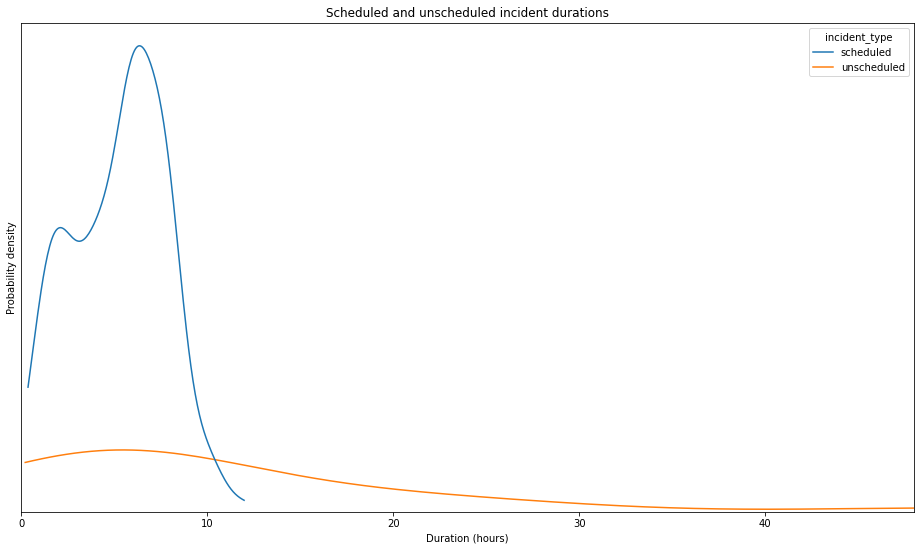

In [40]:
#create a density plot

fig,ax = plt.subplots(figsize=(16,9))
sns.kdeplot(ax=ax, data=durations, x='duration', hue='incident_type', cut=0)

ax.set_xlim(0, 48)
ax.get_yaxis().set_ticks([])

ax.set_title('Scheduled and unscheduled incident durations')
ax.set_xlabel('Duration (hours)')
ax.set_ylabel('Probability density')

Text(0, 0.5, 'Duration (hours)')

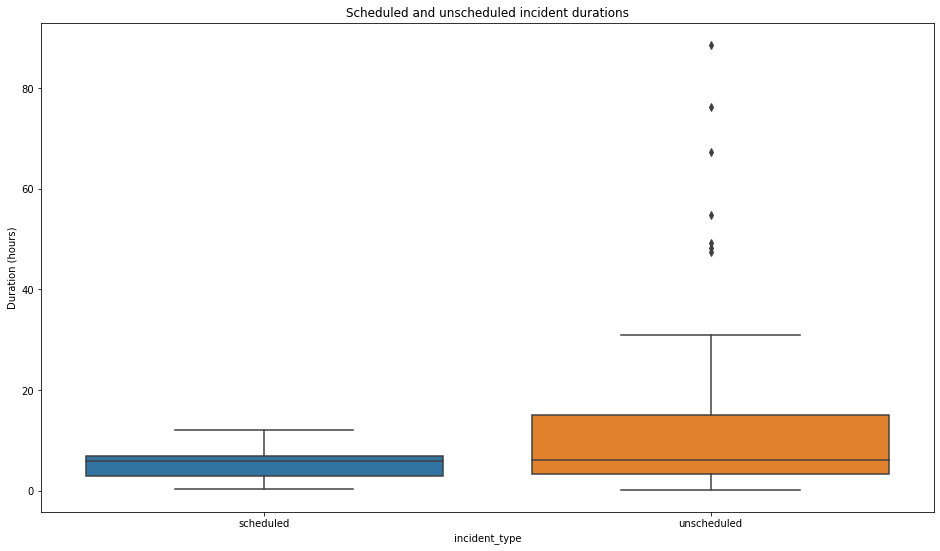

In [41]:
fig,ax = plt.subplots(figsize=(16,9))
sns.boxplot(ax=ax, data=durations, x='incident_type', y='duration')

ax.set_title('Scheduled and unscheduled incident durations')
ax.set_ylabel('Duration (hours)')

Text(0, 0.5, 'Duration (hours)')

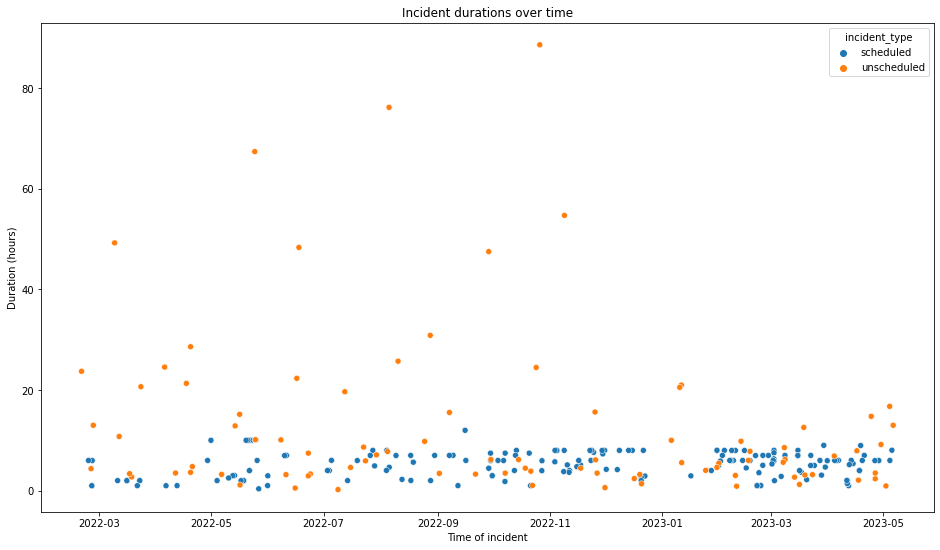

In [42]:
fig,ax = plt.subplots(figsize=(16,9))

sns.scatterplot(ax=ax, data=durations, x='incident_time', y='duration', hue='incident_type')

ax.set_title('Incident durations over time')
ax.set_xlabel('Time of incident')
ax.set_ylabel('Duration (hours)')

The three durations over 60 hours stand out, so we collect the incident links to take a closer look.

In [43]:
unscheduled.sort_values('duration').tail(3)

location             earliest_time  \
221                     163 City Road 2022-05-21 17:50:00+10:00   
187        5 Lawson Street, Southport 2022-08-02 08:00:00+10:00   
143  68 Mt Alexander Road, Travancore 2022-10-22 18:03:00+11:00   

                incident_time incident_type  \
221 2022-05-24 13:11:00+10:00   unscheduled   
187 2022-08-05 12:08:00+10:00   unscheduled   
143 2022-10-26 10:37:00+11:00   unscheduled   

                                         incident_link  duration  
221  https://status.pineapple.net.au/incidents/t8vm...  242460.0  
187  https://status.pineapple.net.au/incidents/mxjx...  274080.0  
143  https://status.pineapple.net.au/incidents/gsh4...  318840.0

In [45]:
for idx, row in unscheduled.sort_values('duration').tail(3).iterrows():
    print(row['incident_link'])

https://status.pineapple.net.au/incidents/t8vmrqs1pxc6
https://status.pineapple.net.au/incidents/mxjxvnnt8gm7
https://status.pineapple.net.au/incidents/gsh47l2b301h


Rows 221 and 187 have explanations on the incident webpage as to the reason the resolutions took as long as they did. 

The incident that took the longest to resolve, row 142 (over 80 hours) does not give an explanation.

Upon contacting Pineapple Network directly to determine the reason as to why this incident it took several days to resolve, the explanation given was that the infratructure at this location was still under the old company (Spirit Technology) and hence Pineapple had to first get around various bureaucatic barriers before the actual issue could be resolved. 